## EDA

In [100]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from collections import defaultdict
import pickle as pl
import math
from sklearn.metrics import (precision_recall_curve,
                             PrecisionRecallDisplay)
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt
import os
from ordered_set import OrderedSet
from sklearn.metrics import roc_curve, auc

import warnings
warnings.filterwarnings("ignore")

In [101]:
df = pd.read_csv('papermodeldata(in).csv')

In [102]:
len(df.columns) -5 

51

In [103]:
df['ttd'].isnull().any()
df['fold'].isnull().any()
df['time'].isnull().any()
df['y'].isnull().any()

np.False_

In [104]:
count_labels = df['y'].groupby(df['y']).count()
count_labels[1]/count_labels[0]*100

np.float64(0.6785127250348604)

In [105]:
df['VitalID'].groupby(df['VitalID']).count()

VitalID
1005     12
1007    138
1010    267
1011     53
1013    103
       ... 
8769     13
8770      6
8771      4
8772      8
8773      4
Name: VitalID, Length: 5957, dtype: int64

In [106]:
df_dead = df[df['y'] == 1]
df_alive = df[df['y'] == 0]

In [107]:
df_alive['VitalID'].groupby(df_alive['VitalID']).count()

VitalID
1005     12
1007    138
1010    265
1011     53
1013     98
       ... 
8769     13
8770      6
8771      4
8772      8
8773      4
Name: VitalID, Length: 5948, dtype: int64

In [108]:
df_dead['VitalID'].groupby(df_dead['VitalID']).count()

VitalID
1010    2
1013    5
1017    7
1028    3
1031    3
       ..
8364    2
8501    1
8510    2
8521    3
8549    5
Name: VitalID, Length: 219, dtype: int64

In [109]:
count_folds = df.groupby(['fold','y']).size()
first = None
second = None
count = 0
for i in count_folds:
    count+=1
    if not(first):
        first = i
    else:
        second = i

    if(count==2):
        count = 0
        print((second/first)*100)
        first = None 
        second = None
    

0.674415267613718
0.5912786400591279
0.5741482208959734
0.7453205725417126
0.5463627848891663
0.7854225573358466
0.8354916868577157
0.5309466019417476
0.6714517249363279
0.8686388592968943


In [110]:
df_dropped = df.drop(['VitalID', 'time','fold','ttd'], axis=1)
df_na_dropped = df_dropped.dropna()
df_dead = df_dropped[df_dropped['y'] == 1]
df_alive = df_dropped[df_dropped['y'] == 0]
df_dead_na_dropped = df_na_dropped[df_na_dropped['y'] == 1]
df_alive_na_dropped = df_na_dropped[df_na_dropped['y'] == 0]

In [111]:
print(((len(df_dead)- len(df_dead_na_dropped)) /len(df_dead)) * 100)
print(((len(df_alive) - len(df_alive_na_dropped)) /len(df_alive))*100)

1.6073478760045925
2.0324221579976474


## Data Preparation

In [112]:
# keep the y seprate 
# remove nan values 
# remove duplicate values

In [113]:
# if ttd is there , that means the baby is eventually going to die..
# if ttd<=days , put y = 1
# if ttd>days  , put y =0
def format_y(ttd,y_values,lowerbound,upperbound):
    """
    Assigns binary labels to y_values based on ttd and day bounds.

    Args:
        ttd (pd.Series): Time to death values.
        y_values (pd.Series): Initial label values.
        lowerbound (int): Lower day bound.
        upperbound (int): Upper day bound.

    Returns:
        pd.Series: Updated binary labels.
    """
    for index in range(len(ttd)):
        if(lowerbound<=ttd[index]<=upperbound):
            y_values[index] = 1
        else:
            y_values[index] = 0
    return y_values

In [114]:
from scipy.stats.mstats import winsorize
def winsorize_col(column):
    """
    Winsorizes a pandas Series to limit extreme values.

    Args:
        column (pd.Series): Input data column.

    Returns:
        np.ndarray: Winsorized column.
    """
    return winsorize(column, limits=(0.001, .001))

def winsorize_df(df):
    """
    Applies winsorization to all columns in a DataFrame.

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: Winsorized DataFrame.
    """
    return df.apply(winsorize_col,axis=0)

In [115]:
def create_df(df,day):
    """
    Prepares the DataFrame for modeling by formatting labels, dropping unnecessary columns,
    removing duplicates and NaNs, and winsorizing features.

    Args:
        df (pd.DataFrame): Input DataFrame.
        day (tuple): Day bounds for label formatting.

    Returns:
        tuple: (features DataFrame, fold assignments, labels)
    """
    ttd = df['ttd']
    y_arr = df['y']
    y_arr = format_y(ttd,y_arr,day[0],day[1])
    df['y'] = y_arr
    # change the y column in the df to the y_arr

    # we only care if the trainign data colun values contain NaN values 
    df_drop_col = df.drop(['VitalID','ttd','time'], axis=1)
    df_drop_col_dup = df_drop_col.drop_duplicates()
    df_drop_col_dup_na = df_drop_col_dup.dropna()

    y_arr = df_drop_col_dup_na['y']
    fold_arr = df_drop_col_dup_na['fold']

    df_drop_col_dup_na.drop(['y','fold'], axis=1,inplace=True)
    df = winsorize_df(df_drop_col_dup_na)
    return df,fold_arr,y_arr

In [116]:
Basics = [ "VitalID","time","fold","ttd","y"]

Demographics = ['bwt', 'ega', 'male', 'apgar5']

HR = ['HR.SB.MotifTwo.diff.uu', 'HR.SB.MotifTwo.diff.uuu','HR.ST.LocalExtrema.l25.diffmaxabsmin', 'HR.std','HR.SB.MotifThree.diffquant.hhhh',
       'HR.EX.MovingThreshold.a0.25.b0.1.meanqover', 'HR.DN.cv.3','HR.SB.MotifTwo.iqr.ddd','HR.SY.StdNthDer.5','HR.ST.LocalExtrema.l25.maxmaxmed', 'HR.SY.StdNthDer.17', 'HR.Quantile.99', 'HR.FC.Suprise.tstat',
       'HR.SB.MotifThree.quantile.hhhh','HR.EX.MovingThreshold.a0.25.b0.05.meanqover','HR.PH.Walkerrunningvar...sw.meanabsdiff', 'HR.CO.tc3.1..denom', 'HR.mean',
       'HR.skew2','HR.SB.TransitionMatrix23.sumdiagcov','HR.ST.LocalExtrema.n100.minabsmin', 'HR.kurt2', 'HR.MF.arfit.sbc.7'
       ]

SPO2 = [ 'SP.EX.MovingThreshold.a0.25.b0.1.meanqover', 'SP.EX.MovingThreshold.a1.b0.25.iqrq', 'SP.PH.Walkerbiasprop.0.1..0.5..sw.meanabsdiff',
'SP.EX.MovingThreshold.a0.25.b0.1.maxq', 'SP.PH.Walkerprop.0.9..w.std', 'SP.skew2','SP.SB.MotifTwo.diff.dduu','SP.DN.RemovePointsmin.0.2.mean',
'SP.PH.Walkermomentum.2..sw.stdrat','SP.CO.tc3.1..denom','SP.mean','SP.kurt2', 'SP.SB.MotifThree.diffquant.hhh','SP.SB.MotifTwo.mean.dddd',
'SP.AutoCorr.lag.4','SP.SB.TransitionMatrix41.ondiag', 'SP.SB.MotifThree.quantile.baaa','SP.std', 'SP.SB.TransitionMatrix21.T10', 'SP.SB.BinaryMethod.iqr.pstretch1'
,'SP.PH.Walkerprop.0.9..sw.stdrat','SP.MF.arfit.sbc.7','SP.SB.TransitionMatrix22.mineig','SP.ST.LocalExtrema.n100.minabsmin']

In [117]:
def create_diff_dfs(df,df_dict):
    """
    Creates different feature DataFrames based on specified feature groups.

    Args:
        df (pd.DataFrame): Input DataFrame.
        df_dict (dict): Mapping of index to feature group name.

    Returns:
        list: List of DataFrames for each feature group.
    """
    df_hr = df[Basics + HR]
    df_spo2 = df[Basics + SPO2]
    df_demographics = df[Basics + Demographics]
    df_hr_spo2 = df[Basics + HR + SPO2] 
    df_hr_spo2_demographics = df[Basics + HR + SPO2 + Demographics]
    data_dict = {'df_hr': df_hr,'df_spo2':df_spo2,'df_demographics':df_demographics,'df_hr_spo2':df_hr_spo2,'df_hr_spo2_demographics':df_hr_spo2_demographics}
    
    df_arr = []
    for i in df_dict:
        df_arr.append(0)
    
    for index in df_dict:
        df_val = df_dict[index]
        df_arr[index] = data_dict[df_val]
    return df_arr

In [118]:
# [df_hr,df_spo2,df_demographics,df_hr_spo2,df_hr_spo2_demographics] = create_diff_dfs(df)

# for i in [df_hr,df_spo2,df_demographics,df_hr_spo2,df_hr_spo2_demographics]:
#     print(i.groupby(['fold', 'y']).agg(Count=("VitalID","count")).reset_index())
#     print("\n\n\n")

## Model Training and Generating results

In [134]:
def generate_logits_arr(no_of_logits):
    """
    Generates an array of threshold logits for classification.

    Args:
        no_of_logits (int): Number of logits to generate.

    Returns:
        list: Sorted list of logits.
    """
    # base_logit = 0.1/int(no_of_logits/2)
    # other_logit = 1/int(no_of_logits/2)
    # logits_arr_base = ([base_logit*i for i in range(1,int(no_of_logits/2)+1)])[::-1]
    # logits_arr_other = ([other_logit*i for i in range(1,int(no_of_logits/2)+1)])[::-1]
    # for logit in logits_arr_base:
    #     logits_arr_other.append(logit)
    # logits_arr = sorted(logits_arr_other)
    
    x = np.linspace(0, 1, no_of_logits)
    k = 1.15
    logits_arr = (np.exp(k*x) - 1) / (np.exp(k) - 1)
    return logits_arr

In [135]:
logits_arr = generate_logits_arr(10000)

(array([605., 564., 531., 499., 473., 448., 427., 406., 388., 372., 356.,
        343., 329., 317., 307., 295., 286., 277., 269., 260., 253., 245.,
        239., 233., 226., 221., 215., 210., 205., 201.]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <BarContainer object of 30 artists>)

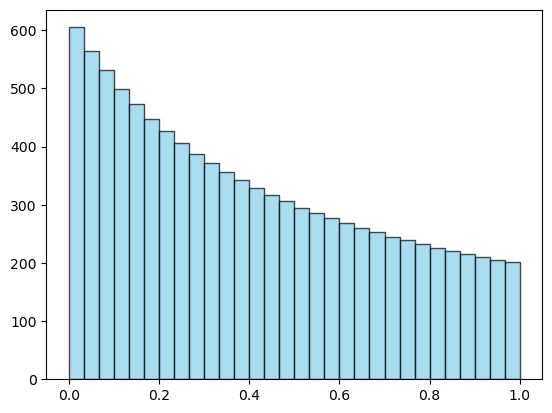

In [136]:
plt.hist(logits_arr, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

In [137]:
def compute_metrics(y_pred,y_true):
    """
    Computes recall, precision, and false positive rate.

    Args:
        y_pred (np.ndarray): Predicted binary labels.
        y_true (np.ndarray): True binary labels.

    Returns:
        tuple: (recall, precision, false positive rate)
    """
    true_positives = sum(np.logical_and(y_pred==1,y_true==1))
    false_negatives = sum(np.logical_and(y_pred == 0, y_true==1))
    false_positives = sum(np.logical_and(y_pred == 1, y_true==0))
    true_negatives = sum(np.logical_and(y_pred==0,y_true==0))

    recall = true_positives/(true_positives+false_negatives)
    precision = true_positives/(true_positives+false_positives)
    fpr = false_positives/(false_positives+true_negatives)
    
    return recall,precision,fpr

In [138]:
def store_results(results,recalls_arr,precisions_arr,false_positive_rates_arr,roc_auc_scores,auprc_scores,cv_scores,curr_features):
    """
    Stores evaluation metrics and feature information in the results dictionary.

    Args:
        results (dict): Dictionary to store results.
        recalls_arr (list): Recall values for each fold.
        precisions_arr (list): Precision values for each fold.
        false_positive_rates_arr (list): FPR values for each fold.
        roc_auc_scores (list): ROC-AUC scores for each fold.
        auprc_scores (list): AUPRC scores for each fold.
        cv_scores (list): Cross-validation accuracy scores.
        curr_features (list): Current feature names.
    """
    # Store results
    results['num_features'].append(len(curr_features))
    results['cv_score_mean'].append(np.mean(cv_scores))
    results['cv_score_std'].append(np.std(cv_scores))
    results['roc_auc_score'].append(np.mean(roc_auc_scores))
    results['aurpc_score'].append(np.mean(auprc_scores))

    recalls_arr_mean = np.mean(recalls_arr,axis =0)  # true postive rate = recall
    precisions_arr_mean = np.mean(precisions_arr,axis =0)
    false_positive_rates_arr_mean = np.mean(false_positive_rates_arr,axis=0)
    recall_arr_std = np.std(recalls_arr,axis=0)
    precision_arr_std = np.std(precisions_arr,axis=0)
    false_positive_rate_arr_std = np.std(false_positive_rates_arr,axis=0)

    results['recalls_arr_mean'].append(recalls_arr_mean)
    results['precisions_arr_mean'].append(precisions_arr_mean)
    results['false_positive_rates_arr_mean'].append(false_positive_rates_arr_mean)
    results['recall_arr_std'].append(recall_arr_std)
    results['precision_arr_std'].append(precision_arr_std)
    results['false_positive_rate_arr_std'].append(false_positive_rate_arr_std)
    

In [139]:
def update_features(feature_importances,curr_features,decrement,lower_bound):
    """
    Removes least important features based on permutation importance.

    Args:
        feature_importances (list): Feature importances from each fold.
        curr_features (list): Current feature names.
        decrement (int): Number of features to remove.
        lower_bound (int): Minimum number of features to retain.

    Returns:
        bool: True if features were updated, False if lower bound reached.
    """
    orig_curr_features = curr_features
    # Average feature importance across folds
    avg_importance = np.mean(feature_importances, axis=0)

    # Find least important features
    num_to_remove = min(decrement, len(curr_features) - lower_bound)
    
    if num_to_remove == 0:
        return False

    remove_idx = np.argsort(avg_importance)[:num_to_remove]
    remove_features = [curr_features[i] for i in remove_idx]

    # Remove features for next iteration
    # works on feature names....have to ensure feature names are different
    curr_features = [f for f in curr_features if f not in remove_features]
    for i in range(len(orig_curr_features)):
        orig_curr_features.pop()
    
    for feature in curr_features:
        orig_curr_features.append(feature) 
    
    return True

In [140]:
def update_metrics_for_logits(logits_arr,y_scores,y_val):
    """
    Computes recall, precision, and FPR for each logit threshold.

    Args:
        logits_arr (list): List of threshold logits.
        y_scores (np.ndarray): Predicted probabilities.
        y_val (np.ndarray): True labels.

    Returns:
        tuple: (recall_arr, precision_arr, false_positive_rate_arr)
    """
    recall_arr = []
    precision_arr = []
    false_positive_rate_arr = []
    y_val = np.array(y_val)

    for logit in logits_arr:

        y_scores_pred = np.array(y_scores) > logit
        recall,precision,fpr = compute_metrics(y_scores_pred,y_val)

        if(math.isnan(precision)):
            precision_arr.append(1)
        else:
            precision_arr.append(precision)

        recall_arr.append(recall)
        false_positive_rate_arr.append(fpr)
    
    return recall_arr,precision_arr,false_positive_rate_arr

In [141]:
def give_results(df,fold_arr: list,y_arr: list,decrement: int,lower_bound: int,max_iters: int,logits_arr: list):
    """
    Performs iterative feature elimination and cross-validation, storing metrics at each step.

    Args:
        df (pd.DataFrame): Feature DataFrame.
        fold_arr (pd.Series): Fold assignments.
        y_arr (pd.Series): Target labels.
        decrement (int): Number of features to remove per iteration.
        lower_bound (int): Minimum number of features to retain.
        max_iters (int): Maximum iterations for model fitting.
        logits_arr (list): Threshold logits for metrics.

    Returns:
        dict: Results dictionary containing metrics and feature info.
    """
    results = defaultdict(list)
    folds = sorted(fold_arr.unique())
    curr_features = list(df.columns)

    while len(curr_features) >= lower_bound:
        cv_scores = []
        feature_importances = []
        roc_auc_scores = []
        auprc_scores = []

        precisions_arr = []
        recalls_arr = []
        false_positive_rates_arr = []
        y_vals_arr = []
        y_scores_arr = []

        print("Current features: " + str(len(curr_features)))

        for fold_val in folds:

            # Split data
            X_val = df[fold_arr == fold_val][curr_features].to_numpy()
            y_val = y_arr[fold_arr == fold_val].to_numpy()

            X_train = df[fold_arr != fold_val][curr_features].to_numpy()
            y_train = y_arr[fold_arr != fold_val].to_numpy()

            # Fit model
            model = LogisticRegression(max_iter=max_iters,penalty='l2').fit(X_train, y_train)

            # get the test out set scores
            y_pred = model.predict(X_val)
            acc = accuracy_score(y_val, y_pred)
            cv_scores.append(acc)
            
            # Get the probability estimates for the positive class
            y_scores = model.predict_proba(X_val)[:, 1]
            
            y_vals_arr.append(y_val)
            y_scores_arr.append(y_scores)

            # Permutation importance
            perm = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42)
            feature_importances.append(perm.importances_mean)
            roc_auc_scores.append(roc_auc_score(y_val,y_scores))
            auprc_scores.append(average_precision_score(y_val, y_scores))
            
            recall_arr,precision_arr,false_positive_rate_arr = update_metrics_for_logits(logits_arr,y_scores,y_val)
            recalls_arr.append(recall_arr)
            
            precisions_arr.append(precision_arr)
            false_positive_rates_arr.append(false_positive_rate_arr)

        # storing the results in the results_dic
        store_results(results,recalls_arr,precisions_arr,false_positive_rates_arr,roc_auc_scores,auprc_scores,cv_scores,curr_features)
        results['y_val'].append(y_vals_arr)
        results['y_scores'].append(y_scores_arr)
        
        # update the curr_features arr
        if (not(update_features(feature_importances,curr_features,decrement,lower_bound))):
            break

    # Convert results to DataFrame for inspection
    return results

In [142]:
days = OrderedSet(( (0,1), (3,4), (7,8)))
dfs_dict = { 0: 'df_hr_spo2' , 1: 'df_hr_spo2_demographics' }
# days = OrderedSet( ((0,1), ))
# dfs_dict = { 0: 'df_hr_spo2' }
dfs_arr = create_diff_dfs(df,dfs_dict)

In [ ]:
results_dict = defaultdict(list)
no_of_model_features = [5,6] # specifying the lower bound
decrement = 5  # specifying the no of features to decrement by every time

for day in days: 
    print(f"Day: {day}")
    for dataframe_index in range(len(dfs_arr)):
        print(f"{dfs_dict[dataframe_index]}")
        data,fold_arr,y_arr = create_df(dfs_arr[dataframe_index],day)
        results = give_results(data,fold_arr,y_arr,decrement,no_of_model_features[dataframe_index],100,logits_arr)
        results_dict[day].append(results)

Day: (0, 1)
df_hr_spo2
Current features: 47
Current features: 42
Current features: 37
Current features: 32
Current features: 27
Current features: 22
Current features: 17
Current features: 12
Current features: 7
Current features: 5
df_hr_spo2_demographics
Current features: 51
Current features: 46
Current features: 41
Current features: 36
Current features: 31
Current features: 26
Current features: 21
Current features: 16
Current features: 11
Current features: 6
Day: (3, 4)
df_hr_spo2
Current features: 47
Current features: 42
Current features: 37
Current features: 32
Current features: 27
Current features: 22


In [ ]:
# y_vals_arr = results_dict[(0,1)][0]['y_val'][0]
# y_scores_arr = results_dict[(0,1)][0]['y_scores'][0]

# for i in range(len(y_vals_arr)):
#    # PrecisionRecallDisplay.from_predictions(y_vals_arr[i],y_scores_arr[i])
   
#    fpr, tpr, _ = roc_curve(y_vals_arr[i], y_scores_arr[i])
#    roc_auc = auc(fpr, tpr)
#    plt.plot(fpr, tpr, label=f'Fold {i+1} (AUC = {roc_auc:.2f})')
#    # precision,recall,_ = precision_recall_curve(np.array(y_vals_arr[i]),np.array(y_scores_arr[i]))
#    # plot_precision_recall_curve()
   

## Storing and the plotting the results

In [ ]:
with open('./results6.pkl', 'wb') as f:
        # Load the data from the pickle file
        pl.dump(results_dict,f)

In [ ]:
with open('./results6.pkl', 'rb') as f:
        # Load the data from the pickle file
        loaded_data = pl.load(f)

In [ ]:
def store_plots(results_dir,loaded_data):
    """
    Saves plots and tables of results for each day and feature group.

    Args:
        results_dir (str): Directory to save results.
        loaded_data (dict): Results data loaded from pickle.
    """
    output_dir = results_dir

    # Create the directory if it doesn't exist
    if not os.path.isdir(output_dir):
        os.makedirs(output_dir)
        
    for day in days: 
        # create dir for day
        
        output_dir = results_dir
        filename = f"Day: {day}"
        day_filepath = os.path.join(output_dir, filename)
        if not os.path.isdir(day_filepath):
            os.makedirs(day_filepath)
        
        
        for dataframe_index in range(len(dfs_arr)):
            
            # creating the plots
            
            # create dir for dataframe_index..this is the last dir
            output_dir =  day_filepath
            filename = f"{dfs_dict[dataframe_index]}"
            df_filepath = os.path.join(output_dir, filename)
            if not os.path.isdir(df_filepath):
                os.makedirs(df_filepath)
            
            
            result = loaded_data[day][dataframe_index]

            x_precisions = np.array(result['precisions_arr_mean'])
            x_recalls = np.array(result['recalls_arr_mean'])
            x_fprs = np.array(result['false_positive_rates_arr_mean'])
            
            x_precision_stds = np.array(result['precision_arr_std'])
            x_recall_stds = np.array(result['recall_arr_std'])
            x_fpr_stds = np.array(result['false_positive_rate_arr_std'])
            
            roc_auc_scores = result['roc_auc_score']
            aurpc_scores = result['aurpc_score']
            num_features = result['num_features']
            
            
            fig, axes = plt.subplots(nrows=1, ncols=len(x_precisions), figsize=(5 * len(x_precisions), 5),squeeze=False)
            
            for plot_index in range(len(x_precisions)):
                
                ax=axes[0][plot_index]
                
                x_precision = x_precisions[plot_index]
                x_recall = x_recalls[plot_index]
                
                x_precision_std = x_precision_stds[plot_index]
                x_recall_std = x_recall_stds[plot_index]
            
                aurpc_score = aurpc_scores[plot_index]
                
                lower = np.maximum(x_precision - x_precision_std, 0.0).reshape(-1)
                upper = np.minimum(x_precision + x_precision_std, 1.0).reshape(-1)
                ax.plot(x_recall,x_precision, color="blue")
                ax.set_title("Precision Recall curve")
                ax.set_xlim(0,1)
                ax.set_ylim(0,1)
                ax.fill_between(x_recall.reshape(-1), lower, upper, alpha=0.3,color='0.8')
                ax.text(0.5, 0.5, f'Auprc score: {int(aurpc_score*1000)/1000}', fontsize=12, color='red')
                ax.text(0.5, 0.4, f'No of features: {num_features[plot_index]}', fontsize=12, color='red')
                ax.set_xlabel("Recall")
                ax.set_ylabel("Precision")
                
            plt.tight_layout()
            plt.savefig(f"{df_filepath}/PR curve.png", dpi=300, bbox_inches="tight")
            plt.close()
            
            
            fig, axes = plt.subplots(nrows=1, ncols=len(x_fprs), figsize=(5 * len(x_fprs), 5),squeeze=False)
            
            for plot_index in range(len(x_fprs)):
                
                ax=axes[0][plot_index]
                
                x_recall = x_recalls[plot_index]
                x_fpr = x_fprs[plot_index]
            
                x_recall_std = x_recall_stds[plot_index]
                roc_auc_score = roc_auc_scores[plot_index]
                
                lower = np.maximum(x_recall - x_recall_std, 0.0).reshape(-1)
                upper = np.minimum(x_recall + x_recall_std, 1.0).reshape(-1)
                ax.plot(x_fpr,x_recall, color="blue")
                ax.set_title("ROC-AUC curve")
                ax.set_xlim(0,1)
                ax.set_ylim(0,1)
                ax.fill_between(x_fpr.reshape(-1), lower, upper, alpha=0.3,color='0.8')
                ax.text(0.5, 0.5, f'AUC-ROC score: {int(roc_auc_score*1000)/1000}', fontsize=12, color='red')
                ax.text(0.5, 0.4,  f'No of features: {num_features[plot_index]}', fontsize=12, color='red')
                ax.set_xlabel("FPR")
                ax.set_ylabel("Recall")

                
            plt.tight_layout()
            plt.savefig(f"{df_filepath}/ROC-AUC curve.png", dpi=300, bbox_inches="tight")
            plt.close()


            fig, axes = plt.subplots(nrows=1, ncols=len(x_precisions), figsize=(5 * len(x_precisions), 5),squeeze=False)

            columns = ['recall','precision']
            for plot_index in range(len(x_precisions)):
                
                ax=axes[0][plot_index]
                ax.axis('off')
                
                values = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
                data = []
                
                for value in values:
                    recall_values = abs(x_recalls[plot_index] - value)
                    index = np.argmin(recall_values)
                    recall = recall_values[index]
                    
                    # if(recall>0.01):
                    #     print(recall)
                    #     print(f"True Day: {day}  df_index: {dataframe_index}  plot_index: {plot_index}")
                    #     print(len(np.unique(loaded_data[day][dataframe_index]['y_scores'][plot_index][0])))
                    #     print('\n')
                        
                    precision =  x_precisions[plot_index][index]
                    data.append([value,precision])
            
                    
                table = ax.table(cellText=data, colLabels=columns, loc='center')
                ax.text(0.5, 0.07,  f'No of features: {num_features[plot_index]}', fontsize=12, color='red')
                ax.text(0.5, 0.14,  f'AUC-ROC score: {int(aurpc_scores[plot_index]*1000)/1000}', fontsize=12, color='red')
            
            plt.tight_layout()
            plt.savefig(f"{df_filepath}/tables.png", dpi=300, bbox_inches="tight")
            plt.close()


In [32]:
result = loaded_data[(0,7)][0]

x_recalls = np.array(result['recalls_arr_mean'])
x_fprs = np.array(result['false_positive_rates_arr_mean'])

x_recall_stds = np.array(result['recall_arr_std'])
x_fpr_stds = np.array(result['false_positive_rate_arr_std'])

roc_auc_scores = result['roc_auc_score']
num_features = result['num_features']

In [ ]:
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(interp_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability\n(Positive label '{target_names[1]}')",
)
ax.legend(loc="lower right")
plt.show()

0.011829647212397099
True Day: (0, 1)  df_index: 0  plot_index: 0


AttributeError: 'list' object has no attribute 'reshape'

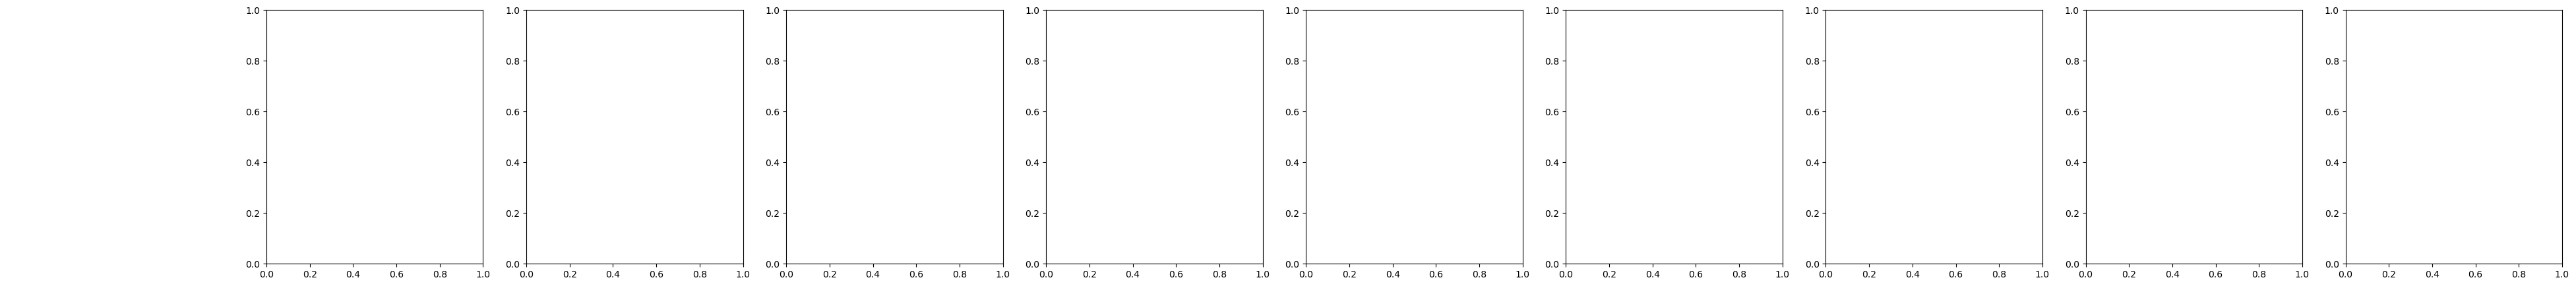

In [70]:
store_plots('/Users/adityagoyal/De sktop/Research - yin li/baseline/results5',loaded_data)

In [ ]:
# Precision is basically out of all the datapoints you predicted as a class, how much of that is correct.
# Recall is basically, out of all the datapoints belonging to that class, how much were you able to predict correctly.
# You can get this intuition for either of the classes, especially for the imbalanced class 

In [ ]:
# positive and negative are the two classes
# The true positive rate is a measure of the probability that an actual positive instance will be classified as positive.
# The true negative rate is a measure of the probability that an actual negative instance will be classified as negative. 
# he false positive rate is essentially a measure of how often a "false alarm" will occur – or, how often an actual negative instance will be classified as positive. (actually this metric says inofrmation aboput the other class!!!!)

In [ ]:
# precision = tp/(tp+fp)
# recall = tp/(tp + fn)  (also known as the true positive rate)
# f1 = 2*precision*recall/ (precision + recall)

In [ ]:
# when we talk about metrics we talk about only pertaining to one class
# true positive rate = tp/(tp + fn) 
# false positive rate = fp(falsely predicted negative datapoints)/fp+tn (all the negative datapoints)

In [ ]:
# Your use case determines how much importance you give to partiuclar evaluation metrics and which evluation metrics you use and on which class - the 0 or the 1

In [ ]:
# for each fold(hold out set): 
    # Get the predicted logits
    # figure out the different values of the boundary logits (from 0 to 1) say k (like randomly generate unformly spaced values)
    # get the precision recall values for each of the boundary logits 

# average out the precision scores at a particualr boundary logit across the various folds 
# average out the recall scores at a particualr boundary logit across the various folds 
# take the stadnard deviation of the precision socres at a particualr boundary logit across the various folds 
# take the stadnard deviation of the recall socres at a particualr boundary logit across the various folds 

# shape of the precision scores: (folds,k)
# shape of the recall curves: (folds,k)

In [ ]:
# for each fold(hold out set): 
    # Get the predicted logits
    # figure out the different values of the boundary logits (from 0 to 1) say k (like randomly generate unformly spaced values)
    # get the tpr and fpr values for each of the boundary logits 

# average out the tpr socres at a particualr boundary logit across the various folds 
# average out the fpr scores at a particualr boundary logit across the various folds 
# take the stadnard deviation of the tpr socres at a particualr boundary logit across the various folds 
# take the stadnard deviation of the fpr socres at a particualr boundary logit across the various folds 

# shape of the tpr scores: (folds,k)
# shape of the fpr curves: (folds,k)

In [ ]:
# while (curr_no_of_features(variable) >= 5)
    # for the different no of folds(variable)
        # take only that fold dataset from the df(variable) and its corresponding y for validation 
        # the rest of the data will be used to train the model

        # fit the model 
        # do the inference on the hold out set 
        # store the cv accuracy score 

        # call the permuation_importance function and provide the fitted model and hold out set as arguments 
        # store the feature importance of all the features 

    # average out the feature importance across the folds and get the argmin 
    # store the no of features 
    # store the average of the cv scores
    # store the standard deviation of the cv scores

    # no_of_features to decrease = min(5,curr_no_features-5)
    # if(no_of_features to decrease):
    #      break
    # remove the features from the dataset and continue with the changed dataset 

# Arguments: df(the dataset features), fold_arr, y_arr

In [ ]:
# try different feature elimination methods 
# do different regularization methods 
# see if NaN values should be removed 
# solve the issue of roc-auc curves

In [ ]:
# the model architecture 
# read the rnn paper again...tell abrar the entire experimental setup.
# # you have to capture as mich essence as possible

In [57]:
# A precision–recall (PR) curve is built by sorting unique predicted probabilities (y_prob) and sweeping a threshold from 1 → 0.
# Each threshold gives you one (precision, recall) pair.
# So the number of recall points = number of unique score thresholds (≤ number of samples).

# Because recall = TP / (TP + FN) changes only when a new positive sample flips from FN → TP,
# → recall values form a stepwise, discrete set 

In [ ]:
# save the features, store the y_scores, target label